# MIMIC-III & Subgroup Sepsis EDA

In [1]:
import psycopg2
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
conn = psycopg2.connect(
    host="localhost",
    database="mimic",
    user="postgres"
    #, password = [your password], 
    # port = 5431 [change to postgres port]
)

cursor = conn.cursor()

## All Patients Basic Info

In [3]:
#Loading in data
basic_patient_df = pd.read_sql_query('''SELECT subject_id, gender, dob
FROM mimiciii.patients;''', conn)
basic_patient_df.head()

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_72455/2568416342.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  basic_patient_df = pd.read_sql_query('''SELECT subject_id, gender, dob


,subject_id,gender,dob
0,249,F,2075-03-13
1,250,F,2164-12-27
2,251,M,2090-03-15
3,252,M,2078-03-06
4,253,F,2089-11-26


In [4]:
basic_patient_df.groupby('gender').count().reset_index()

,gender,subject_id,dob
0,F,20399,20399
1,M,26121,26121


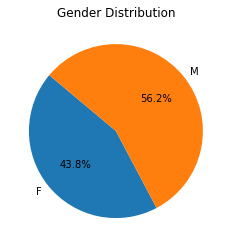

In [5]:
plt.pie(basic_patient_df.groupby('gender').count().reset_index()['subject_id'], labels=basic_patient_df.groupby('gender').count().reset_index()['gender'], autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.show()

## Subgroup Basic Patient Info

In [19]:
sub1_cardiopul = pd.read_csv('subgroup_7.csv')
sub2_young = pd.read_csv('subgroup_5.csv')
sub3_hep_add = pd.read_csv('subgroup_3.csv')
sub4_comp_diab = pd.read_csv('subgroup_1.csv')
sub5_uncomp_diab = pd.read_csv('subgroup_4.csv')
sub6_cardiac = pd.read_csv('subgroup_2.csv')

# cardiopulmanary = pd.read_csv('subgroup_7.csv')
# young = pd.read_csv('subgroup_5.csv')
# hepatic_addiction = pd.read_csv('subgroup_3.csv')
# complicated_diabetes = pd.read_csv('subgroup_1.csv')
# uncomplicated_diabetes = pd.read_csv('subgroup_4.csv')
# cardiac = pd.read_csv('subgroup_2.csv')

In [20]:
sub1_cardiopul.head()

,subject_id,hadm_id,rounded_age,admission_type_encoded,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,...,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression,age,subgroup
0,36,122659,70,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,70,7
1,109,126055,24,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,24,7
2,111,155897,69,1,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,69,7
3,125,157348,51,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,51,7
4,138,108120,48,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,48,7


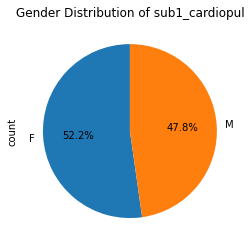

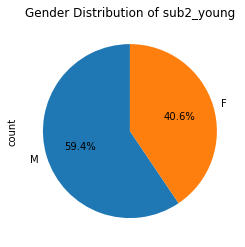

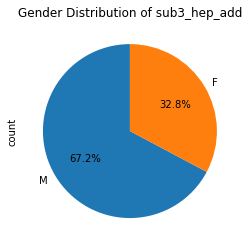

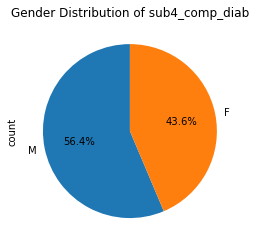

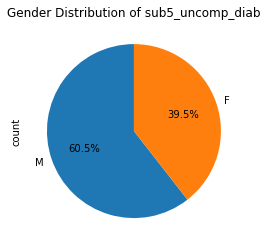

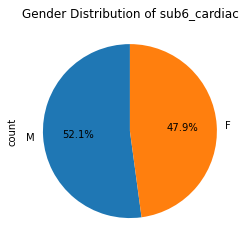

In [21]:
subgroups = [sub1_cardiopul, sub2_young, sub3_hep_add, sub4_comp_diab, sub5_uncomp_diab, sub6_cardiac]
subgroup_names = ['sub1_cardiopul', 'sub2_young', 'sub3_hep_add', 'sub4_comp_diab', 'sub5_uncomp_diab', 'sub6_cardiac']

def get_gender_distribution(subgroup_df, patient_info_df, name):
    merged_df = pd.merge(subgroup_df, patient_info_df[['subject_id', 'gender']], on='subject_id', how='left')

    result_df = merged_df[['subject_id', 'gender']]
    # print(result_df)

    gender_distribution = result_df['gender'].value_counts()
    gender_distribution.plot.pie(autopct='%1.1f%%', startangle=90)
    plt.title('Gender Distribution of ' + name)
    plt.show()

for i, j in zip(subgroups, subgroup_names):
    get_gender_distribution(i, basic_patient_df, j)


#get_gender_distribution(sub1_cardiopul, basic_patient_df)


In [22]:
query= '''-- ------------------------------------------------------------------
-- Title: Detailed information on ICUSTAY_ID
-- Description: This query provides a useful set of information regarding patient
--              ICU stays. The information is combined from the admissions, patients, and
--              icustays tables. It includes age, length of stay, sequence, and expiry flags.
-- MIMIC version: MIMIC-III v1.3
-- ------------------------------------------------------------------

-- This query extracts useful demographic/administrative information for patient ICU stays

SELECT ie.subject_id, ie.hadm_id, ie.icustay_id

-- patient level factors
, pat.gender, pat.dod

-- hospital level factors
, adm.admittime, adm.dischtime
, DATE_PART('day', adm.dischtime) - DATE_PART('day', adm.admittime) AS los_hospital
, CASE 
    WHEN DATE_PART('year', ie.intime) - DATE_PART('year', pat.dob) >= 300 THEN 90
    ELSE DATE_PART('year', ie.intime) - DATE_PART('year', pat.dob) 
  END AS admission_age
, adm.ethnicity
, CASE 
    WHEN adm.ethnicity IN (
        'WHITE', 'WHITE - RUSSIAN', 'WHITE - OTHER EUROPEAN', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN'
    ) THEN 'white'
    WHEN adm.ethnicity IN (
        'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN', 'BLACK/AFRICAN', 'CARIBBEAN ISLAND'
    ) THEN 'black'
    WHEN adm.ethnicity IN (
        'HISPANIC OR LATINO', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 
        'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - SALVADORAN', 
        'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - MEXICAN', 
        'HISPANIC/LATINO - COLOMBIAN', 'HISPANIC/LATINO - HONDURAN'
    ) THEN 'hispanic'
    WHEN adm.ethnicity IN (
        'ASIAN', 'ASIAN - CHINESE', 'ASIAN - ASIAN INDIAN', 'ASIAN - VIETNAMESE', 'ASIAN - FILIPINO', 
        'ASIAN - CAMBODIAN', 'ASIAN - OTHER', 'ASIAN - KOREAN', 'ASIAN - JAPANESE', 'ASIAN - THAI'
    ) THEN 'asian'
    WHEN adm.ethnicity IN (
        'AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE'
    ) THEN 'native'
    WHEN adm.ethnicity IN (
        'UNKNOWN/NOT SPECIFIED', 'UNABLE TO OBTAIN', 'PATIENT DECLINED TO ANSWER'
    ) THEN 'unknown'
    ELSE 'other' 
  END AS ethnicity_grouped
, adm.hospital_expire_flag
, DENSE_RANK() OVER (PARTITION BY adm.subject_id ORDER BY adm.admittime) AS hospstay_seq
, CASE
    WHEN DENSE_RANK() OVER (PARTITION BY adm.subject_id ORDER BY adm.admittime) = 1 THEN true
    ELSE false END AS first_hosp_stay

-- icu level factors
, ie.intime, ie.outtime
, DATE_PART('day', ie.outtime - ie.intime) AS los_icu
, DENSE_RANK() OVER (PARTITION BY ie.hadm_id ORDER BY ie.intime) AS icustay_seq

-- first ICU stay *for the current hospitalization*
, CASE
    WHEN DENSE_RANK() OVER (PARTITION BY ie.hadm_id ORDER BY ie.intime) = 1 THEN true
    ELSE false END AS first_icu_stay

FROM mimiciii.icustays ie
INNER JOIN mimiciii.admissions adm ON ie.hadm_id = adm.hadm_id
INNER JOIN mimiciii.patients pat ON ie.subject_id = pat.subject_id
WHERE adm.has_chartevents_data = 1
ORDER BY ie.subject_id, adm.admittime, ie.intime;

'''

age_df = pd.read_sql_query(query, conn)
age_df

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_72455/2545855307.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  age_df = pd.read_sql_query(query, conn)


,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,admission_age,ethnicity,ethnicity_grouped,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,first_icu_stay
0,2,163353,243653,M,NaT,2138-07-17 19:04:00,2138-07-21 15:48:00,4.0,0.0,ASIAN,asian,0,1,True,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0,1,True
1,3,145834,211552,M,2102-06-14,2101-10-20 19:08:00,2101-10-31 13:58:00,11.0,76.0,WHITE,white,0,1,True,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0,1,True
2,4,185777,294638,F,NaT,2191-03-16 00:28:00,2191-03-23 18:41:00,7.0,48.0,WHITE,white,0,1,True,2191-03-16 00:29:31,2191-03-17 16:46:31,1.0,1,True
3,5,178980,214757,M,NaT,2103-02-02 04:31:00,2103-02-04 12:15:00,2.0,0.0,ASIAN,asian,0,1,True,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0,1,True
4,6,107064,228232,F,NaT,2175-05-30 07:15:00,2175-06-15 16:00:00,-15.0,66.0,WHITE,white,0,1,True,2175-05-30 21:30:54,2175-06-03 13:39:54,3.0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61046,99985,176670,279638,M,NaT,2181-01-27 02:47:00,2181-02-12 17:05:00,-15.0,54.0,WHITE,white,0,1,True,2181-01-29 05:33:34,2181-02-09 12:45:20,11.0,1,True
61047,99991,151118,226241,M,NaT,2184-12-24 08:30:00,2185-01-05 12:15:00,-19.0,47.0,WHITE,white,0,1,True,2184-12-28 17:30:58,2184-12-31 20:56:20,3.0,1,True
61048,99992,197084,242052,F,NaT,2144-07-25 18:03:00,2144-07-28 17:56:00,3.0,66.0,WHITE,white,0,1,True,2144-07-25 18:04:42,2144-07-27 17:27:55,1.0,1,True
61049,99995,137810,229633,F,2147-09-29,2147-02-08 08:00:00,2147-02-11 13:15:00,3.0,89.0,WHITE,white,0,1,True,2147-02-08 13:53:58,2147-02-10 17:46:30,2.0,1,True


In [12]:
newagedf = age_df.groupby('admission_age').count()
newagedf

,subject_id,hadm_id,icustay_id,gender,dod,admittime,dischtime,los_hospital,ethnicity,ethnicity_grouped,hospital_expire_flag,hospstay_seq,first_hosp_stay,intime,outtime,los_icu,icustay_seq,first_icu_stay
admission_age,,,,,,,,,,,,,,,,,,
0.0,8058,8058,8058,8058,64,8058,8058,8058,8058,8058,8058,8058,8058,8058,8051,8051,8058,8058
1.0,29,29,29,29,0,29,29,29,29,29,29,29,29,29,29,29,29,29
15.0,8,8,8,8,1,8,8,8,8,8,8,8,8,8,8,8,8,8
16.0,11,11,11,11,2,11,11,11,11,11,11,11,11,11,11,11,11,11
17.0,51,51,51,51,8,51,51,51,51,51,51,51,51,51,51,51,51,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86.0,786,786,786,786,555,786,786,786,786,786,786,786,786,786,786,786,786,786
87.0,731,731,731,731,486,731,731,731,731,731,731,731,731,731,731,731,731,731
88.0,586,586,586,586,402,586,586,586,586,586,586,586,586,586,586,586,586,586


### All Patient Age

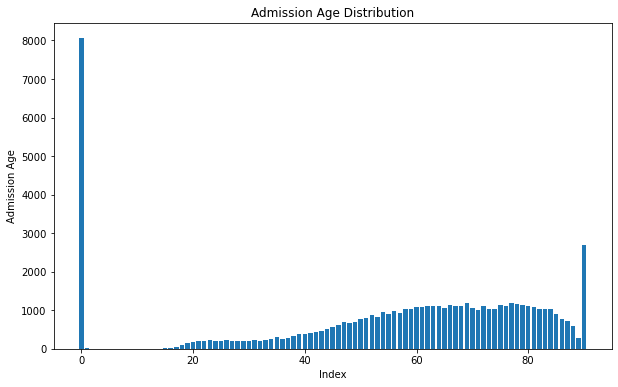

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(newagedf.index,newagedf.subject_id)
plt.xlabel('Index')
plt.ylabel('Admission Age')
plt.title('Admission Age Distribution')
plt.show()

In [24]:
import matplotlib.pyplot as plt

def plot_age_distribution(subgroup_df, name):
    plt.figure(figsize=(10, 6))
    plt.hist(subgroup_df['rounded_age'], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Age Distribution of Patients in {name}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Subgroup Age

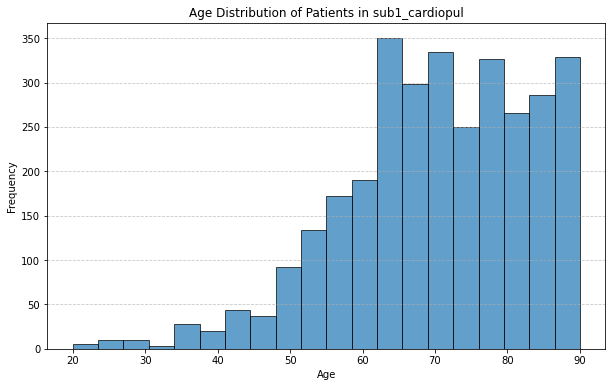

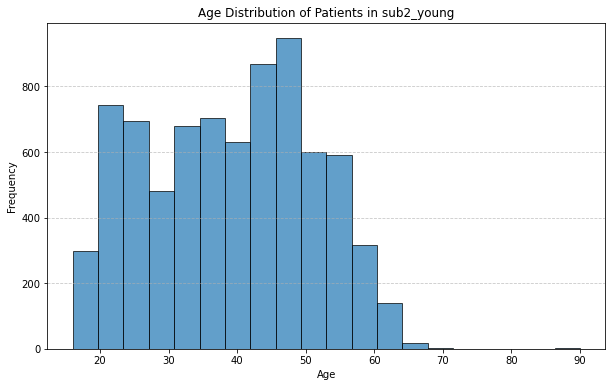

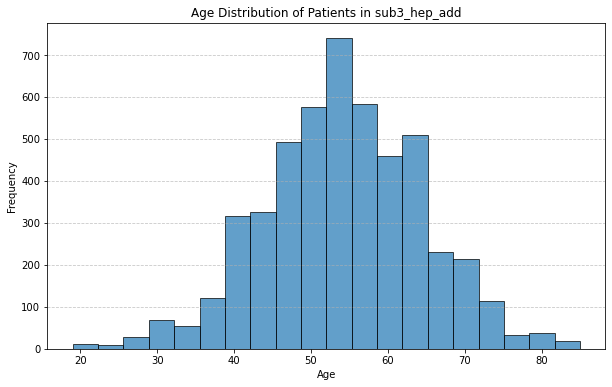

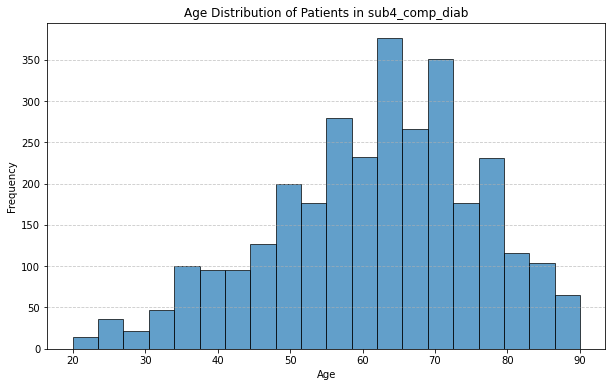

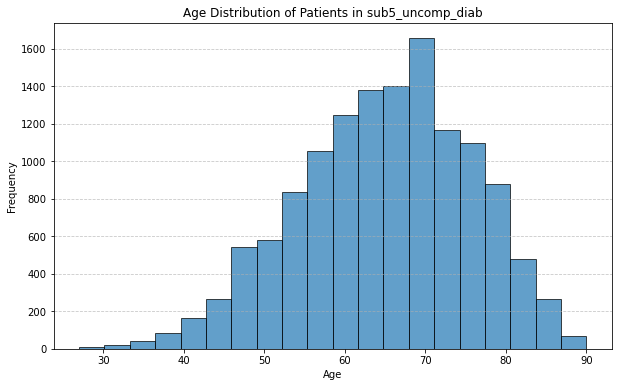

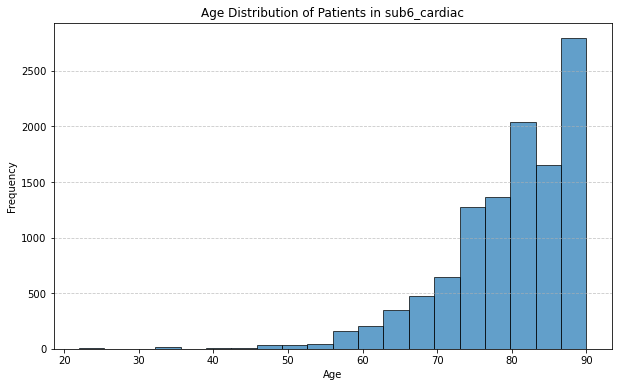

In [25]:
for subgroup_df, subgroup_name in zip(subgroups, subgroup_names):
    plot_age_distribution(subgroup_df, subgroup_name)

In [26]:
zero_age = age_df[age_df['admission_age']==0]
((zero_age.isna().sum()['dod'])/zero_age.shape[0])*100

99.20575825266815

# Patient Vitals

### All Patients Blood Urine Nitrogen 

In [27]:
bun_query = '''WITH agetbl AS
(
    SELECT
        ad.subject_id,
        CASE 
            WHEN EXTRACT(YEAR FROM ad.admittime) - EXTRACT(YEAR FROM p.dob) >= 300 THEN 90
            ELSE EXTRACT(YEAR FROM ad.admittime) - EXTRACT(YEAR FROM p.dob)
        END AS age
    FROM mimiciii.admissions ad
    INNER JOIN mimiciii.patients p ON ad.subject_id = p.subject_id
    WHERE EXTRACT(YEAR FROM ad.admittime) - EXTRACT(YEAR FROM p.dob) > 15
)
, bun AS
(
    SELECT a.subject_id, a.age, width_bucket(le.valuenum, 0, 280, 280) AS bucket
    FROM agetbl a
    INNER JOIN mimiciii.labevents le ON le.subject_id = a.subject_id
    WHERE le.itemid IN (51006)
)
SELECT
    subject_id,
    age,
    AVG(bucket) AS mean_bun,
    STDDEV(bucket) AS std_dev_bun
FROM bun
GROUP BY subject_id, age
ORDER BY subject_id, age;
'''
bun_df = pd.read_sql_query(bun_query, conn)

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_72455/2491792514.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bun_df = pd.read_sql_query(bun_query, conn)


In [28]:
bun_df.head()

,subject_id,age,mean_bun,std_dev_bun
0,3,76.0,34.236842,11.090376
1,4,48.0,17.754717,5.707302
2,6,66.0,39.500000,26.818386
3,9,41.0,23.714286,6.047432
4,11,50.0,16.370370,3.001899


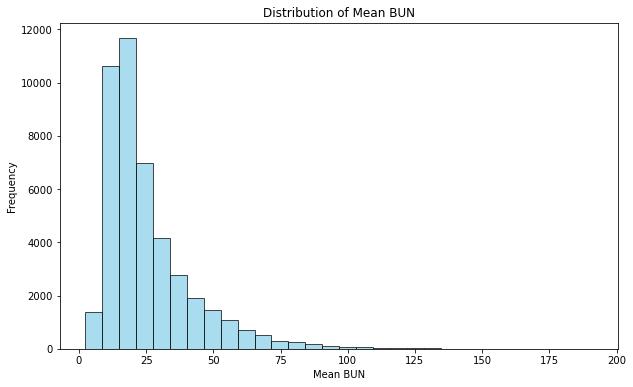

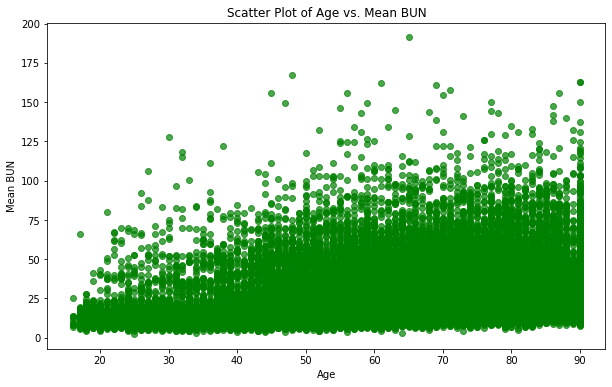

<Figure size 864x576 with 0 Axes>

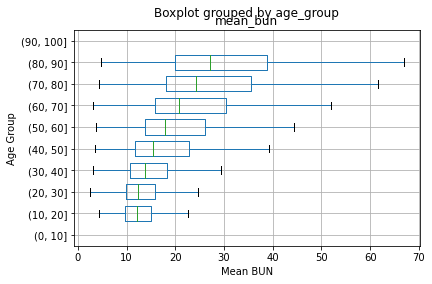

In [29]:

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize mean BUN distribution
plt.figure(figsize=(10, 6))
plt.hist(bun_df['mean_bun'].to_numpy(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Mean BUN')
plt.xlabel('Mean BUN')
plt.ylabel('Frequency')
plt.show()


# Visualize relationship between age and mean BUN
plt.figure(figsize=(10, 6))
plt.scatter(bun_df['age'].to_numpy(), bun_df['mean_bun'].to_numpy(), color='green', alpha=0.7)
plt.title('Scatter Plot of Age vs. Mean BUN')
plt.xlabel('Age')
plt.ylabel('Mean BUN')
plt.show()

# Visualize boxplot of mean BUN by age group
plt.figure(figsize=(12, 8))
bun_df['age_group'] = pd.cut(bun_df['age'], bins=range(0, 101, 10))
bun_df.boxplot(column='mean_bun', by='age_group', vert=False, widths=0.7, showfliers=False)

#plt.title('Boxplot of Mean BUN by Age Group')
plt.xlabel('Mean BUN')
plt.ylabel('Age Group')
plt.show()


### Subgroup Patients Blood Urine Nitrogen

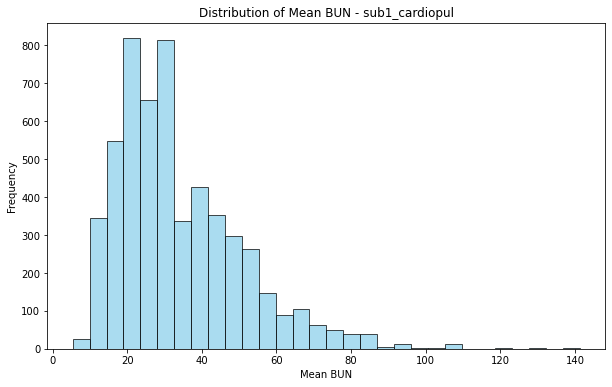

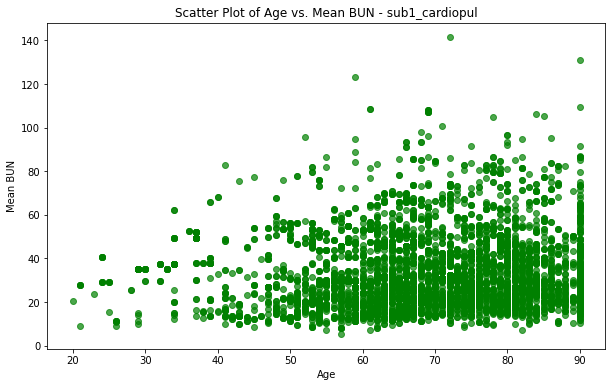

<Figure size 864x576 with 0 Axes>

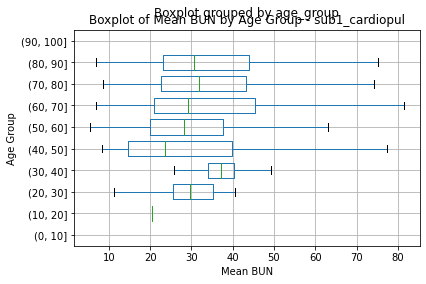

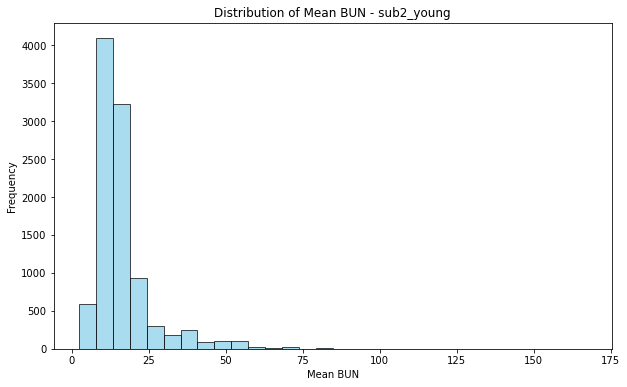

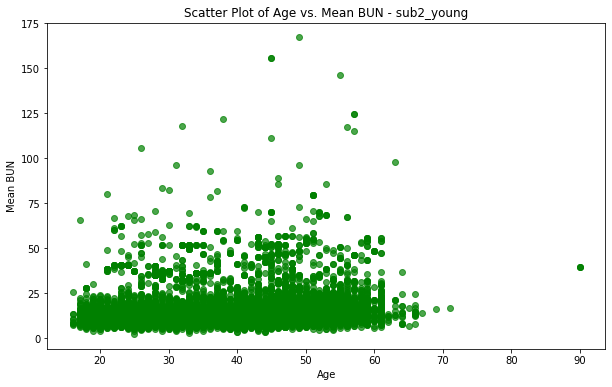

<Figure size 864x576 with 0 Axes>

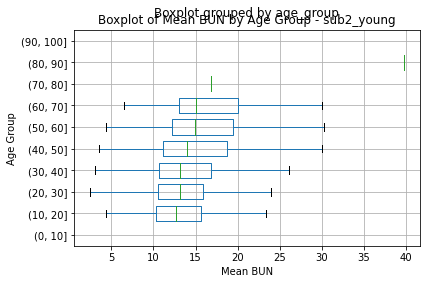

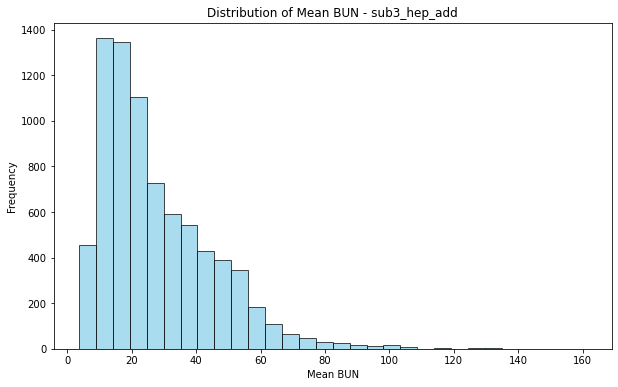

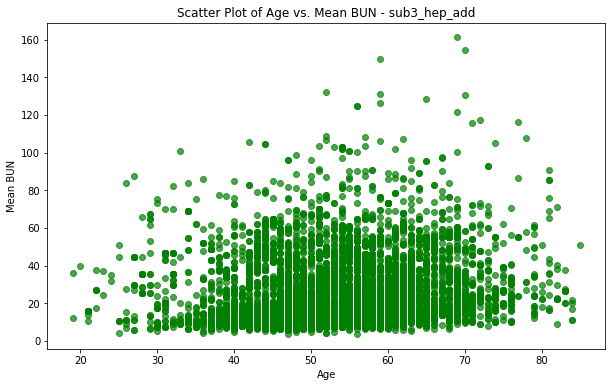

<Figure size 864x576 with 0 Axes>

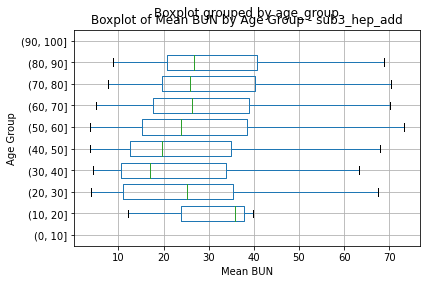

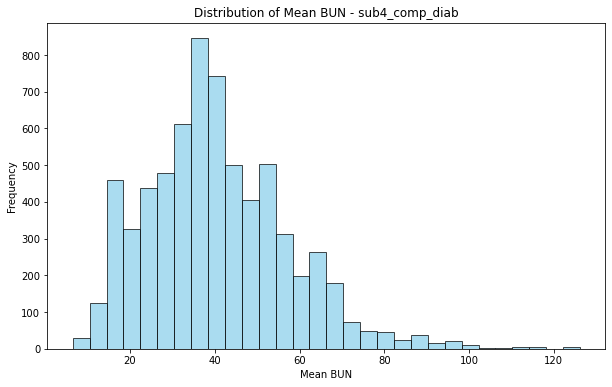

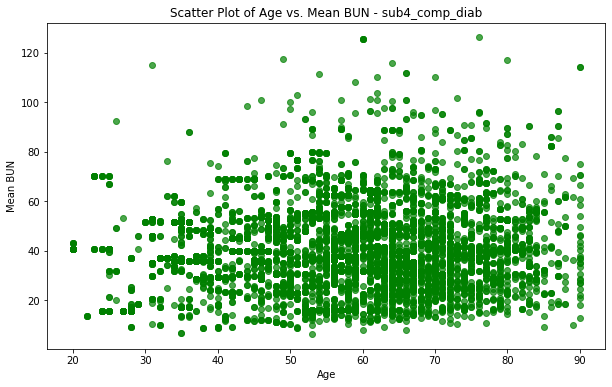

<Figure size 864x576 with 0 Axes>

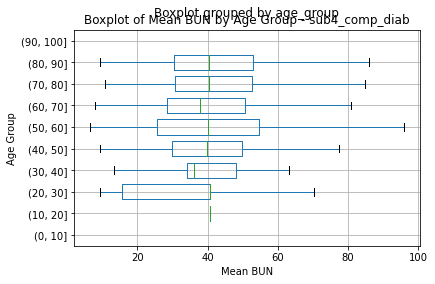

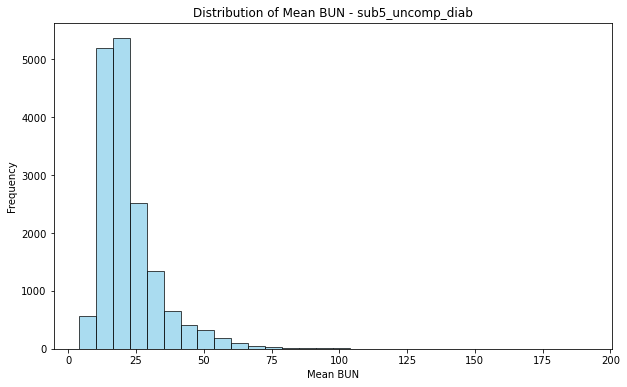

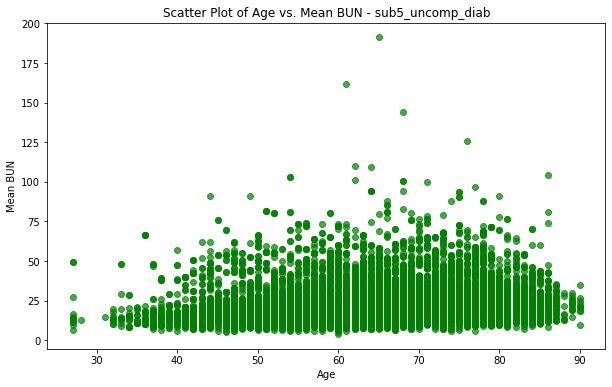

<Figure size 864x576 with 0 Axes>

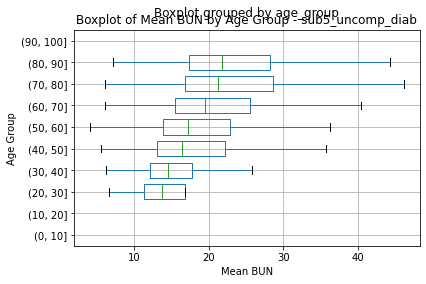

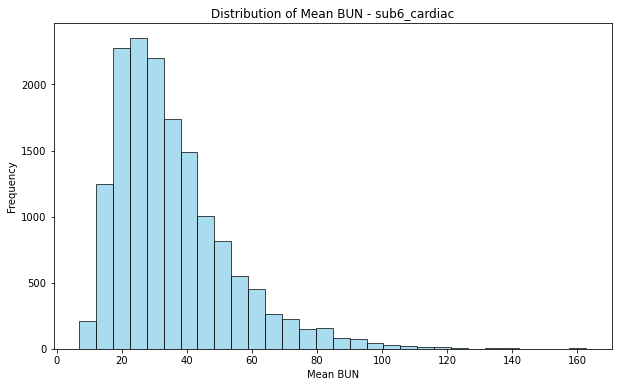

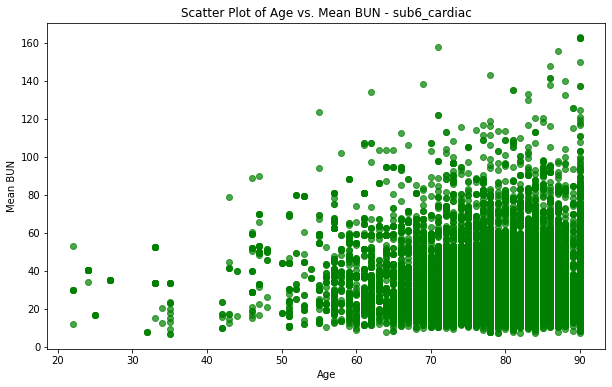

<Figure size 864x576 with 0 Axes>

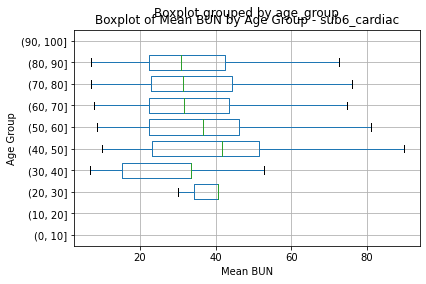

In [30]:
def plot_bun_distribution(subgroup_df, bun_df, table_name):
    # Merge tables to get bun values for the subgroup patients
    merged_df = pd.merge(subgroup_df, bun_df[['subject_id', 'age', 'mean_bun']], on='subject_id', how='left')

    # Visualize mean BUN distribution
    plt.figure(figsize=(10, 6))
    plt.hist(merged_df['mean_bun'].to_numpy(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Mean BUN - {table_name}')
    plt.xlabel('Mean BUN')
    plt.ylabel('Frequency')
    plt.show()

    # Visualize relationship between age and mean BUN
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['rounded_age'].to_numpy(), merged_df['mean_bun'].to_numpy(), color='green', alpha=0.7)
    plt.title(f'Scatter Plot of Age vs. Mean BUN - {table_name}')
    plt.xlabel('Age')
    plt.ylabel('Mean BUN')
    plt.show()

    # Visualize boxplot of mean BUN by age group
    plt.figure(figsize=(12, 8))
    merged_df['age_group'] = pd.cut(merged_df['rounded_age'], bins=range(0, 101, 10))
    merged_df.boxplot(column='mean_bun', by='age_group', vert=False, widths=0.7, showfliers=False)
    plt.title(f'Boxplot of Mean BUN by Age Group - {table_name}')
    plt.xlabel('Mean BUN')
    plt.ylabel('Age Group')
    plt.show()

for subgroup, name in zip(subgroups, subgroup_names):
    plot_bun_distribution(subgroup, bun_df, name)

### All Patient GCS Motor Scores

In [31]:
gcs_motor_query = '''-- Title: Find the average Glasgow Coma MOTOR score for each adult patient
-- Notes: this query does not specify a schema. To run it on your local
-- MIMIC schema, run the following command:
--  SET SEARCH_PATH TO mimiciii;
-- Where "mimiciii" is the name of your schema, and may be different.
-- --------------------------------------------------------

WITH agetbl AS
(
    SELECT
        ad.subject_id,
        CASE
            WHEN EXTRACT(YEAR FROM ad.admittime) - EXTRACT(YEAR FROM p.dob) >= 300 THEN 90
            ELSE EXTRACT(YEAR FROM ad.admittime) - EXTRACT(YEAR FROM p.dob)
        END AS age
    FROM mimiciii.admissions ad
    INNER JOIN mimiciii.patients p
    ON ad.subject_id = p.subject_id
    WHERE
        -- filter to only adults
        EXTRACT(YEAR FROM ad.admittime) - EXTRACT(YEAR FROM p.dob) > 15
    -- group by subject_id to ensure there is only 1 subject_id per row
    GROUP BY ad.subject_id, age
)
, gcs AS
(
    SELECT a.subject_id, a.age, width_bucket(ce.valuenum, 1, 30, 30) AS bucket
    FROM agetbl a
    INNER JOIN mimiciii.chartevents ce
    ON ce.subject_id = a.subject_id
    WHERE ce.itemid IN (454, 223900) -- "Motor Response" and "GCS - Motor Response"
)
SELECT
    subject_id,
    age,
    AVG(bucket) AS avg_GCS_Motor_Response,  -- Calculating average GCS Motor score
    COUNT(*) AS count
FROM gcs
GROUP BY subject_id, age
ORDER BY subject_id, age;
'''
gcs_df = pd.read_sql_query(gcs_motor_query, conn)
gcs_df

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_72455/4033073548.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  gcs_df = pd.read_sql_query(gcs_motor_query, conn)


,subject_id,age,avg_gcs_motor_response,count
0,3,76.0,5.500000,29
1,4,48.0,6.000000,9
2,6,66.0,6.000000,27
3,9,41.0,1.907895,76
4,11,50.0,5.882353,17
...,...,...,...,...
44133,99985,54.0,1.808824,68
44134,99991,47.0,5.000000,22
44135,99992,66.0,5.000000,11
44136,99995,89.0,4.333333,12


In [32]:
gcs_df.head()

,subject_id,age,avg_gcs_motor_response,count
0,3,76.0,5.500000,29
1,4,48.0,6.000000,9
2,6,66.0,6.000000,27
3,9,41.0,1.907895,76
4,11,50.0,5.882353,17


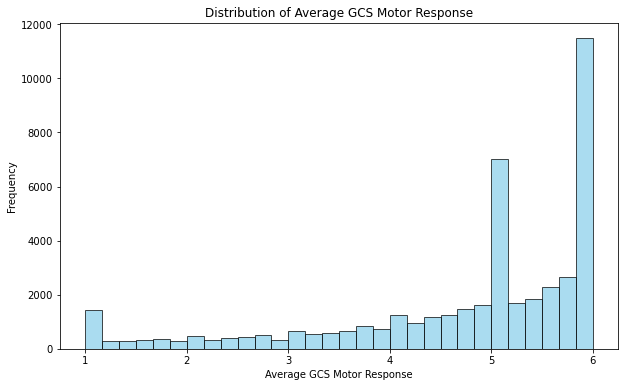

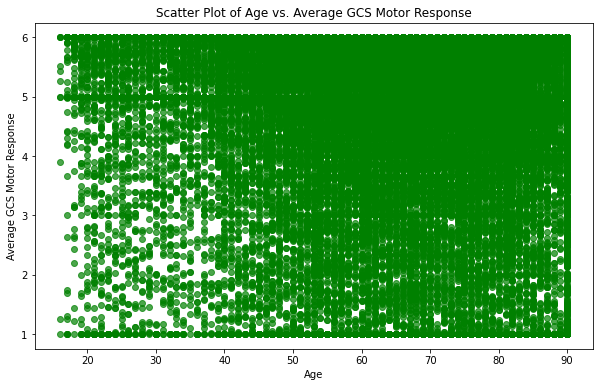

<Figure size 864x576 with 0 Axes>

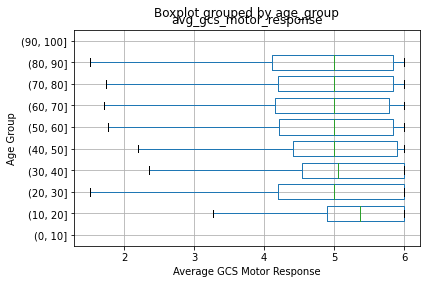

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(gcs_df['avg_gcs_motor_response'].to_numpy(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Average GCS Motor Response')
plt.xlabel('Average GCS Motor Response')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(gcs_df['age'].to_numpy(), gcs_df['avg_gcs_motor_response'].to_numpy(), color='green', alpha=0.7)
plt.title('Scatter Plot of Age vs. Average GCS Motor Response')
plt.xlabel('Age')
plt.ylabel('Average GCS Motor Response')
plt.show()

plt.figure(figsize=(12, 8))
gcs_df['age_group'] = pd.cut(gcs_df['age'], bins=range(0, 101, 10))
gcs_df.boxplot(column='avg_gcs_motor_response', by='age_group', vert=False, widths=0.7, showfliers=False)
#plt.title('Boxplot of Average GCS Motor Response by Age Group')
plt.xlabel('Average GCS Motor Response')
plt.ylabel('Age Group')
plt.show()


### Subgroup Patient GCS Motor Scores

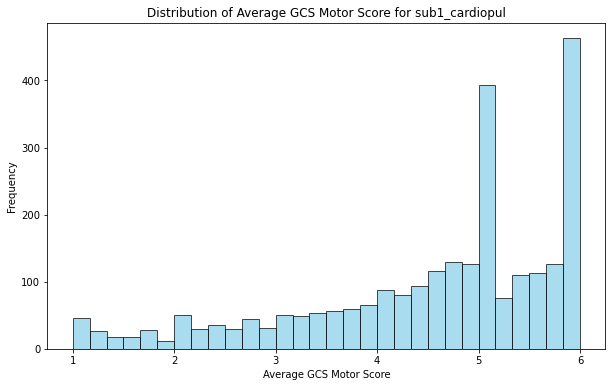

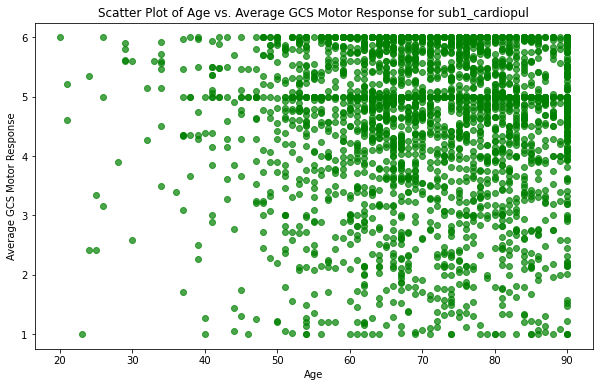

<Figure size 864x576 with 0 Axes>

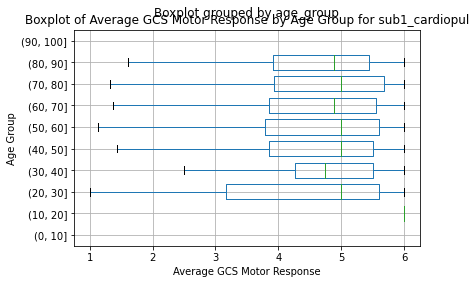

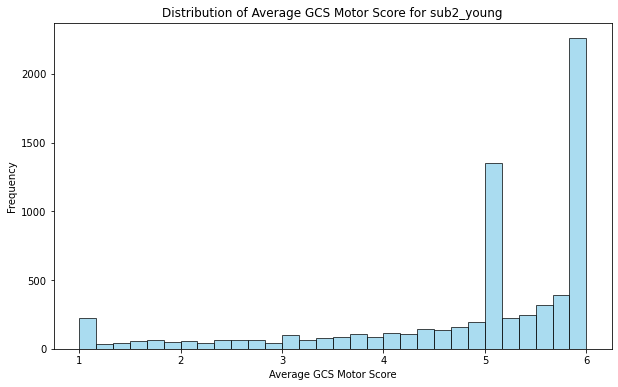

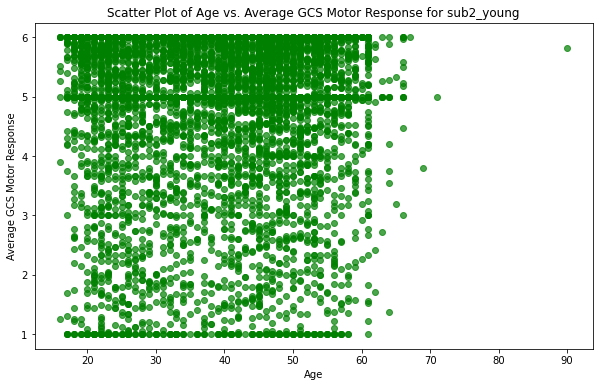

<Figure size 864x576 with 0 Axes>

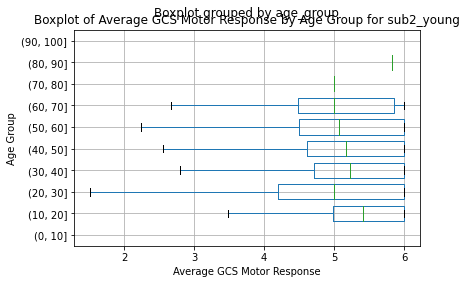

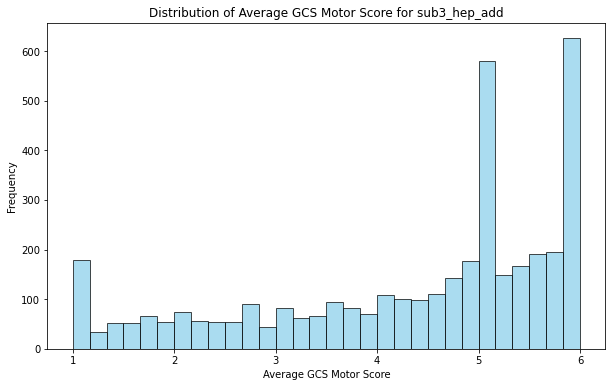

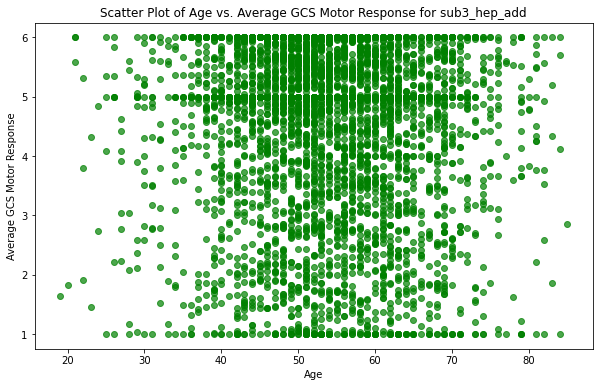

<Figure size 864x576 with 0 Axes>

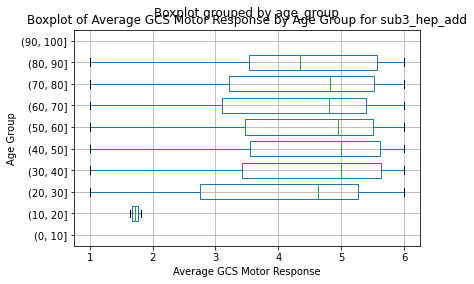

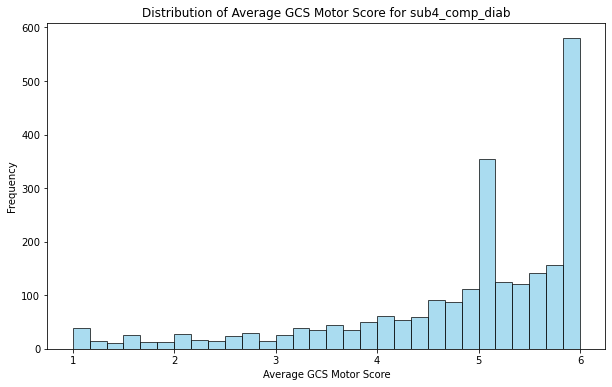

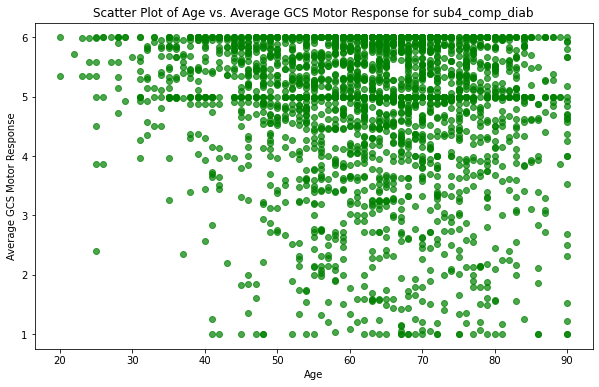

<Figure size 864x576 with 0 Axes>

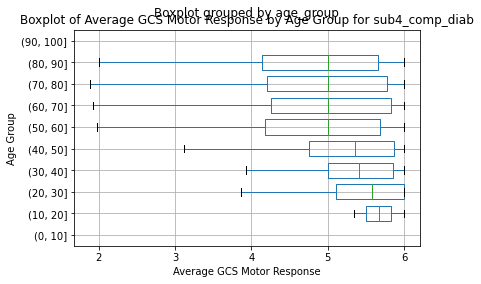

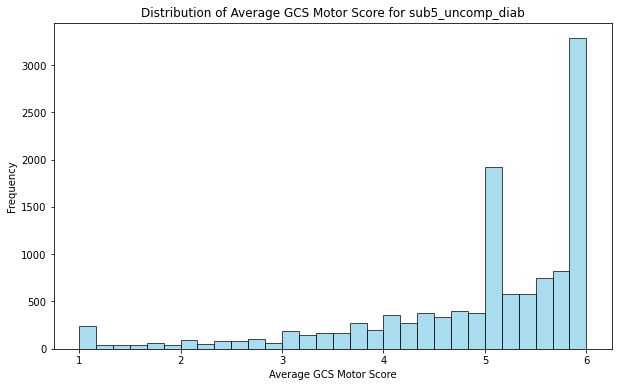

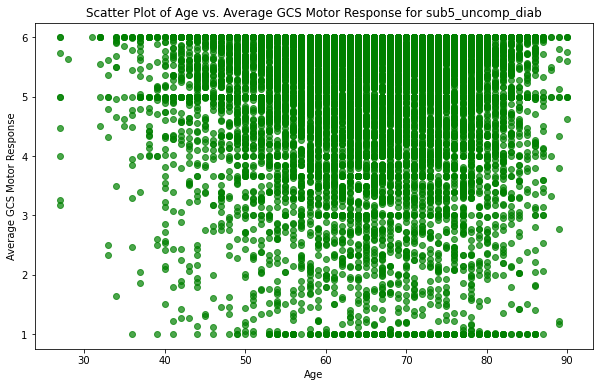

<Figure size 864x576 with 0 Axes>

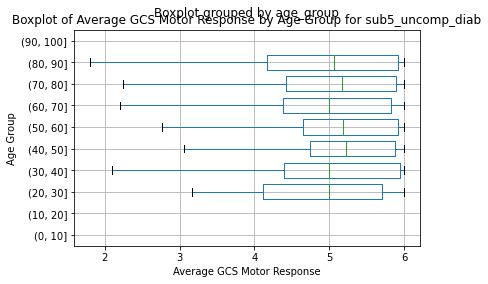

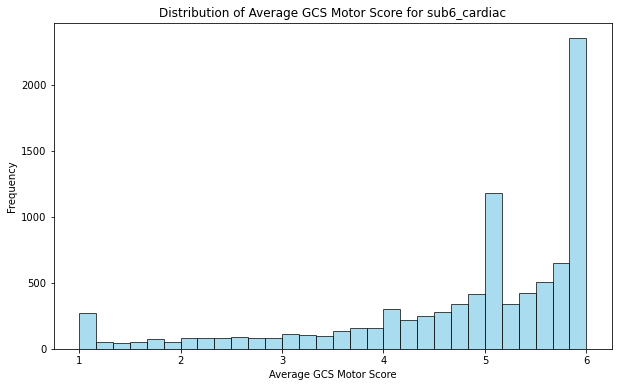

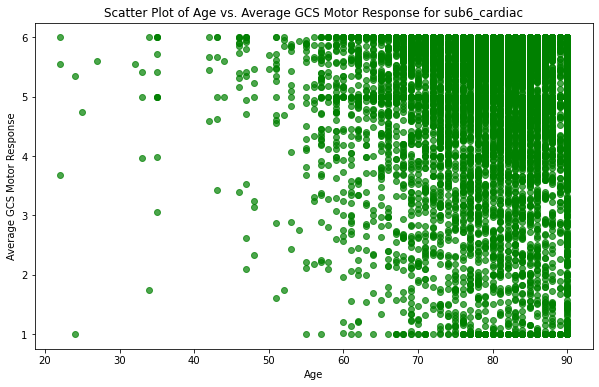

<Figure size 864x576 with 0 Axes>

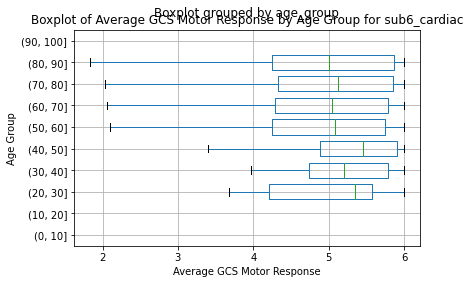

In [34]:
def get_gcs_motor_distribution(subgroup_df, patient_info_df, name):
    # Merge the subgroup table with patient information
    merged_df = pd.merge(subgroup_df, patient_info_df[['subject_id', 'age', 'avg_gcs_motor_response']], on='subject_id', how='left')

    # Explicitly create a copy to avoid SettingWithCopyWarning
    result_df = merged_df[['subject_id', 'rounded_age', 'avg_gcs_motor_response']].copy()

    # Rename the 'age' column to 'rounded_age' for consistency
    result_df.rename(columns={'age': 'rounded_age'}, inplace=True)

    # Add a case for age values 300 and over
    result_df['rounded_age'] = result_df['rounded_age'].apply(lambda x: 90 if x >= 300 else x)

    # Assuming you have a SQL engine to execute the query and get the results as a DataFrame
    # Replace the following line with the actual execution of your GCS query
    gcs_df = result_df.groupby(['subject_id', 'rounded_age'])['avg_gcs_motor_response'].mean().reset_index()

    # Plotting average GCS Motor scores
    plt.figure(figsize=(10, 6))
    plt.hist(gcs_df['avg_gcs_motor_response'].to_numpy(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Average GCS Motor Score for ' + name)
    plt.xlabel('Average GCS Motor Score')
    plt.ylabel('Frequency')
    plt.show()

    # Plotting scatter plot of Age vs. Average GCS Motor Response
    plt.figure(figsize=(10, 6))
    plt.scatter(gcs_df['rounded_age'].to_numpy(), gcs_df['avg_gcs_motor_response'].to_numpy(), color='green', alpha=0.7)
    plt.title('Scatter Plot of Age vs. Average GCS Motor Response for ' + name)
    plt.xlabel('Age')
    plt.ylabel('Average GCS Motor Response')
    plt.show()

    # Plotting boxplot of Average GCS Motor Response by Age Group
    plt.figure(figsize=(12, 8))
    gcs_df['age_group'] = pd.cut(gcs_df['rounded_age'], bins=range(0, 101, 10))
    gcs_df.boxplot(column='avg_gcs_motor_response', by='age_group', vert=False, widths=0.7, showfliers=False)
    plt.title('Boxplot of Average GCS Motor Response by Age Group for ' + name)
    plt.xlabel('Average GCS Motor Response')
    plt.ylabel('Age Group')
    plt.show()

# Example usage:
for subgroup, subgroup_name in zip(subgroups, subgroup_names):
    get_gcs_motor_distribution(subgroup, gcs_df, subgroup_name)



### Glucose 

In [35]:
gluc_query = '''
WITH agetbl AS
(
  SELECT ad.subject_id, EXTRACT(YEAR FROM ad.admittime) - EXTRACT(YEAR FROM p.dob) AS age
  FROM mimiciii.admissions ad
  INNER JOIN mimiciii.patients p
  ON ad.subject_id = p.subject_id
  WHERE
  -- filter to only adults
  EXTRACT(YEAR FROM ad.admittime) - EXTRACT(YEAR FROM p.dob) > 15
  -- group by subject_id to ensure there is only 1 subject_id per row
  GROUP BY ad.subject_id, age
)
, glc AS
(
  SELECT a.subject_id, a.age, width_bucket(le.valuenum, 0.5, 1000, 1000) AS bucket
  FROM agetbl a
  INNER JOIN mimiciii.labevents le
  ON le.subject_id = a.subject_id
  WHERE le.itemid IN (50809, 50931)
  AND le.valuenum IS NOT NULL
)
SELECT subject_id, age, bucket AS glucose, count(*)
FROM glc
GROUP BY subject_id, age, bucket
ORDER BY subject_id, age, bucket;'''

gluc_df = pd.read_sql_query(gluc_query, conn)
gluc_df

/var/folders/48/vk7lyccx60x4918_6lqc64fw0000gn/T/ipykernel_72455/1955550544.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  gluc_df = pd.read_sql_query(gluc_query, conn)


,subject_id,age,glucose,count
0,3,76.0,73,1
1,3,76.0,76,1
2,3,76.0,79,1
3,3,76.0,85,1
4,3,76.0,88,1
...,...,...,...,...
1038298,99999,63.0,112,1
1038299,99999,63.0,133,1
1038300,99999,63.0,139,1
1038301,99999,63.0,148,1


##

## Patient Procedures